# Beam Size Fine-tuning

## Imports

In [1]:
import json
from utils.evaluation_metrics import *
from utils.search_funcs import get_prediction, beam_search
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

import matplotlib.pyplot as plt

## Functions

In [2]:
def evaluate_beam_size(sentences_df, sentences_lst, subs, predictor, tokenizer, fluency_model, fluency_tokenizer,  bertscore_model, beam_size):
    counter_sents = []
    for sent in sentences_lst:
        # get original prediction
        pred = get_prediction(model=predictor, tokenizer=tokenizer, text=sent)
        # get original fluency
        fluency = sent_scoring(fluency_model, fluency_tokenizer, sent)[0]
        # get the best counterfactual using beam search
        cs = beam_search(text=sent, substitutions=subs, original_pred=pred, original_fluency=fluency,
                         model=predictor, tokenizer=tokenizer, fluency_model=fluency_model,
                         fluency_tokenizer=fluency_tokenizer, beam_size=beam_size, max_subs=10)
        counter_sents.append(cs)

    counter_sentences = pd.DataFrame({'counter_sents': counter_sents})

    # get evaluation metrics
    fluency = get_fluency(sentences_df, counter_sentences, fluency_model, fluency_tokenizer)
    bertscore = get_bertscore(sentences_df, counter_sentences, bertscore_model)
    closeness = get_closeness(sentences_df, counter_sentences)
    flip_rate = get_flip_rate(sentences_df, counter_sentences, predictor, tokenizer)

    return fluency, bertscore, closeness, flip_rate



## Load Data

In [4]:
sents = pd.read_csv('../Edits/newsgroups/newsgroups.csv')[['text']].sample(100, random_state=17)
sents_lst = sents['text'].tolist()

In [5]:
# load substitution pairs
with open('../Edits/newsgroups/gnn_newsgroups_edge_filter_edits2.json', 'r') as f:
    substitutions = json.load(f)

In [ ]:
# load model and tokenizer for prediction
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('../Predictors/newsgroups_bert_predictor')

In [ ]:
# load model and tokenizer for fluency
fluency_model, fluency_tokenizer = model_init('t5-base', cuda=False)

In [8]:
# load model for bertscore
bertscore_model = load("bertscore")

## Fine-tuning

In [ ]:
beam_size_lst = [3, 5, 7, 9]
fl, brts, cl, fr = [], [], [], []

for bs in beam_size_lst:
    print(f'Beam Size: {bs}')

    fluency, bertscore, closeness, flip_rate = evaluate_beam_size(sentences_df=sents, sentences_lst=sents_lst, subs=substitutions, predictor=model, tokenizer=tokenizer, fluency_model=fluency_model,
     fluency_tokenizer=fluency_tokenizer, bertscore_model=bertscore_model, beam_size=bs)

    fl.append(fluency)
    brts.append(bertscore)
    cl.append(closeness)
    fr.append(flip_rate)

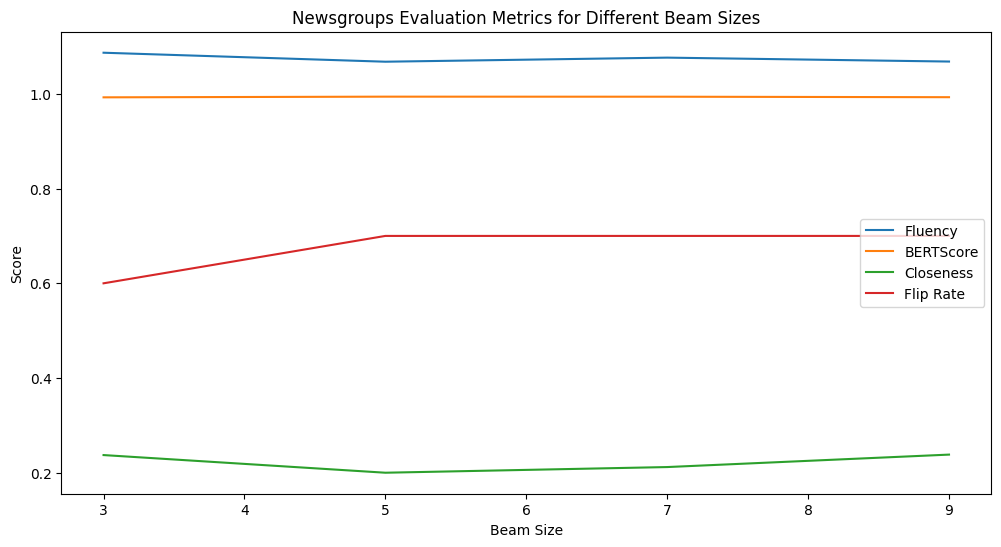

In [18]:
# plot results
plt.figure(figsize=(12, 6))
plt.plot(beam_size_lst, fl, label='Fluency')
plt.plot(beam_size_lst, brts, label='BERTScore')
plt.plot(beam_size_lst, cl, label='Closeness')
plt.plot(beam_size_lst, fr, label='Flip Rate')

plt.xlabel('Beam Size')
plt.ylabel('Score')
plt.title('Newsgroups Evaluation Metrics for Different Beam Sizes')

plt.legend(loc='center right')
plt.show()